In [ ]:
import logging
import time
import os, io
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow_datasets as tfds
import tensorflow as tf

import warnings
import pathlib

import tensorflow_text

In [ ]:
zipFile = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

#filePath = os.path.dirname(zipFile)+"/spa-eng/spa.txt"
filePath = "/root/.keras/datasets/spa-eng_extracted/spa-eng/spa.txt"

2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
! head -10 /root/.keras/datasets/spa-eng_extracted/spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!


In [ ]:
def loadData(path, size=None):
  text = io.open(filePath, encoding='UTF-8').read()
  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]
  sp = np.array([source for target, source in pairs])
  en = np.array([target for target, source in pairs])
  return sp, en

In [ ]:
spSentences , enSentences = loadData(filePath)
print("sp sentences:", spSentences[42])
print("en sentences:", enSentences[42])

sp sentences: Yo lo sé.
en sentences: I know.


In [ ]:
df = pd.DataFrame(zip(spSentences, enSentences), columns=['sp', 'en'])
df

,sp,en
0,Ve.,Go.
1,Vete.,Go.
2,Vaya.,Go.
3,Váyase.,Go.
4,Hola.,Hi.
...,...,...
118959,Hay cuatro causas principales de muertes relac...,There are four main causes of alcohol-related ...
118960,Hay madres y padres que se quedan despiertos d...,There are mothers and fathers who will lie awa...
118961,Una huella de carbono es la cantidad de contam...,A carbon footprint is the amount of carbon dio...
118962,Como suele haber varias páginas web sobre cual...,Since there are usually multiple websites on a...


In [ ]:
import re, itertools
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
import unicodedata

def unicode_to_ascii(s):
    normalized = unicodedata.normalize('NFD', s)
    return ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')

def preprocess_text(text):
  text = unicode_to_ascii(text.lower().strip())
  text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
  text = re.sub(r"([?.!,¿])", r" \1 ", text)
  text = re.sub(r'[" "]+', " ", text)
  text = text.rstrip().strip()

  return text

In [ ]:
print('Original sentence:',spSentences[42])
prc_sp_sentences = [preprocess_text(w) for w in spSentences]
prc_en_sentences = [preprocess_text(w) for w in enSentences]
print('Preprocessed sentence:',prc_sp_sentences[42])

Original sentence: Yo lo sé.
Preprocessed sentence: yo lo se .


In [ ]:
# the following lines will split the datasets into a train and test datasets.
# train data is used to "train" the model and test data is used to eval model.
spSentencesTrain, spSentencesVal, enSentencesTrain, enSentencesVal = train_test_split(prc_sp_sentences, prc_en_sentences, shuffle=False, test_size=0.2)
print(len(spSentencesTrain), len(spSentencesVal), len(enSentencesTrain), len(enSentencesVal))

95171 23793 95171 23793


In [ ]:
#defieneing the hyperparameters that will used within the models

# bufferSire -- bufffer size for the training data
bufferSize = len(spSentencesTrain)
# valBufferSize -- buffer size for the validatation data
valBufferSize = len(spSentencesVal)
# BATCHSIZE -- batch size for the training data
BATCHSIZE = 100
# embeddingDim -- embedding dimension for the input data
embeddingDim = 128
# units -- number of units in. the RNN used for model
units = 1024
# stepsPerEpoch -- number of steps to take each epoch of training
stepsPerEpoch = bufferSize
# valStepsPerEpoch -- validation steps to take during each epoch of training
valStepsPerEpoch = valBufferSize

In [ ]:
trainDatasetUnbatched = tf.data.Dataset.from_tensor_slices((spSentencesTrain, enSentencesTrain))
trainDataset = trainDatasetUnbatched.shuffle(buffer_size=bufferSize).batch(BATCHSIZE)
valDatasetUnbatched = tf.data.Dataset.from_tensor_slices((spSentencesVal, enSentencesVal))
valDataset = valDatasetUnbatched.batch(BATCHSIZE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/
%run dataManagement.ipynb

Mounted at /content/drive
/content/drive/MyDrive
Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!
sp sentences: Yo lo sé.
en sentences: I know.
Original sentence: Yo lo sé.
Preprocessed sentence: yo lo se .
16000 4000 16000 4000
vete .
el cerro los ojos .
go .
he closed his eyes .
CPU times: user 13.7 s, sys: 324 ms, total: 14 s
Wall time: 14.2 s
['[PAD]', '[UNK]', '[START]', '[END]', '!', ',', '.', '?', 'a', 'b']
['quiero', 'todos', '##to', 'necesito', '##ndo', 'su', 'mas', 'puede', 'ir', 'donde']
['##taron', '##tate', '##tido', '##tieron', '##tis', '##tiste', '##tor', '##tre', '##ucha', '##udas']
['##k', '##m', '##p', '##q', '##t', '##u', '##v', '##w', '##x', '##¿']
CPU times: user 5.38 s, sys: 85.1 ms, total: 5.47 s
Wall time: 5.59 s
['[PAD]', '[UNK]', '[START]', '[END]', '!', ',', '.', '?', 'a', 'b']
['ve', 'just', 'at', 'car', 'good', 'all', 'for', 'home', 'where', 'why']
[]
['##,', '##.', '##?', '##c', '##j', 

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'name',
 'name_scope',
 'non_trainable_variables',
 'submodules',
 'tokenize',
 'tokenizer',
 'trainable_variables',
 'variables',
 'vocab',
 'with_name_scope']

In [ ]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
no kidding ?
i ll do it myself .
tell the truth .
i live in turkey .
kick the door in .
he made me go .
no problem !
i m going to pay .
that s personal .
i prefer to walk .
i don t get it .
he must have left .
tom is a bad boy .
we eat at home .
hold me close .
he avoids me .
please call again .
what is that ?
tom paged mary .
go on inside .
i ve had enough .
he is kind .
we all have flaws .
i don t like tom .
tom remembers .
he just arrived .
you re my enemy .
sign here , please .
i play violin .
what do i do next ?
the leaves fell .
i m going to wait .
tom s safe .
he s always busy .
they re insane .
let s go swimming .
they ve gone .
tom always loses .
i ll stop .
i told tom to go .
i m worn out .
who won ?
you re stalling .
tom loves sunsets .
you may go .
tom wants mary .
can we trust tom ?
stop grumbling .
is the milk good ?
do you like dogs ?
it doesn t matter .
why not both ?
give me the map .
bite your tongue .
when do we start ?
mary is tall .
wh

In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 82, 588, 7, 3]
[2, 16, 58, 46, 37, 558, 6, 3]
[2, 154, 41, 534, 6, 3]
[2, 16, 177, 62, 27, 936, 149, 193, 96, 94, 6, 3]
[2, 18, 371, 41, 490, 62, 6, 3]
[2, 38, 152, 40, 54, 6, 3]
[2, 82, 596, 4, 3]
[2, 16, 20, 164, 51, 187, 6, 3]
[2, 43, 26, 907, 197, 6, 3]
[2, 16, 23, 149, 96, 238, 124, 51, 280, 6, 3]
[2, 16, 55, 27, 78, 37, 6, 3]
[2, 38, 128, 56, 203, 6, 3]
[2, 35, 36, 8, 176, 222, 6, 3]
[2, 39, 144, 102, 107, 6, 3]
[2, 261, 40, 254, 6, 3]
[2, 38, 8, 937, 194, 573, 49, 40, 6, 3]
[2, 80, 141, 150, 6, 3]
[2, 61, 36, 43, 7, 3]
[2, 35, 23, 771, 81, 85, 6, 3]
[2, 54, 68, 752, 6, 3]
[2, 16, 100, 160, 491, 6, 3]
[2, 38, 36, 425, 6, 3]
[2, 39, 105, 56, 13, 299, 535, 49, 6, 3]
[2, 16, 55, 27, 64, 35, 6, 3]
[2, 35, 336, 49, 6, 3]
[2, 38, 101, 543, 6, 3]
[2, 34, 42, 50, 359, 6, 3]
[2, 644, 60, 5, 80, 6, 3]
[2, 16, 206, 29, 383, 194, 299, 272, 6, 3]
[2, 61, 46, 16, 46, 593, 7, 3]
[2, 41, 132, 49, 464, 6, 3]
[2, 16, 20, 164, 51, 137, 6, 3]
[2, 35, 26, 39

In [ ]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
no kidding ?
i ll do it myself .
tell the truth .
i live in turkey .
kick the door in .
he made me go .
no problem !
i m going to pay .
that s personal .
i prefer to walk .
i don t get it .
he must have left .
tom is a bad boy .
we eat at home .
hold me close .
he avoids me .
please call again .
what is that ?
tom paged mary .
go on inside .
i ve had enough .
he is kind .
we all have flaws .
i don t like tom .
tom remembers .
he just arrived .
you re my enemy .
sign here , please .
i play violin .
what do i do next ?
the leaves fell .
i m going to wait .
tom s safe .
he s always busy .
they re insane .
let s go swimming .
they ve gone .
tom always loses .
i ll stop .
i told tom to go .
i m worn out .
who won ?
you re stalling .
tom loves sunsets .
you may go .
tom wants mary .
can we trust tom ?
stop grumbling .
is the milk good ?
do you like dogs ?
it doesn t matter .
why not both ?
give me the map .
bite your tongue .
when do we start ?
mary is tall .
w

In [ ]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'no', b'kidding', b'?', b'[END]'],
 [b'[START]', b'i', b'll', b'do', b'it', b'myself', b'.', b'[END]'],
 [b'[START]', b'tell', b'the', b'truth', b'.', b'[END]'],
 [b'[START]', b'i', b'live', b'in', b't', b'##u', b'##r', b'##k', b'##e',
  b'##y', b'.', b'[END]']                                                ,
 [b'[START]', b'k', b'##ick', b'the', b'door', b'in', b'.', b'[END]'],
 [b'[START]', b'he', b'made', b'me', b'go', b'.', b'[END]'],
 [b'[START]', b'no', b'problem', b'!', b'[END]'],
 [b'[START]', b'i', b'm', b'going', b'to', b'pay', b'.', b'[END]'],
 [b'[START]', b'that', b's', b'person', b'##al', b'.', b'[END]'],
 [b'[START]', b'i', b'p', b'##r', b'##e', b'##f', b'##er', b'to', b'walk',
  b'.', b'[END]']                                                         ,
 [b'[START]', b'i', b'don', b't', b'get', b'it', b'.', b'[END]'],
 [b'[START]', b'he', b'must', b'have', b'left', b'.', b'[END]'],
 [b'[START]', b'tom', b'is', b'a', b'bad', b'boy', b'.', b'

In [ ]:
lengths = []

for sp_examples, en_examples in trainDatasetUnbatched.batch(1024):
  sp_tokens = tokenizers.sp.tokenize(sp_examples)
  lengths.append(sp_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

................

Text(0.5, 1.0, 'Maximum tokens per example: 20')

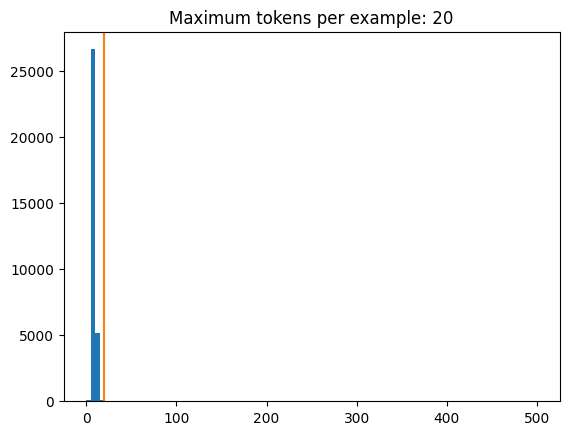

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}')

In [ ]:
MAX_TOKENS=128
def prepare_batch(sp, en):
  sp = tokenizers.sp.tokenize(sp)   # output is raggeed
  sp = sp[:, :MAX_TOKENS] #trim to MAX_TOKENS
  sp = sp.to_tensor()   # convert to padded dense Tensor

  en = tokenizers.en.tokenize(en)
  en = en[:, :(MAX_TOKENS+1)]
  en_inputs = en[:, :-1].to_tensor() # drop the [END]
  en_labels = en[:, 1:].to_tensor() # drop the [START]

  return (sp, en_inputs), en_labels

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
# Create training and validation set batches.
train_batches = make_batches(trainDatasetUnbatched)
val_batches = make_batches(valDatasetUnbatched)

In [ ]:
for (sp, en), en_labels in train_batches.take(1):
  break

print(sp.shape)
print(en.shape)
print(en_labels.shape)

(64, 17)
(64, 11)
(64, 11)


In [ ]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([  2  75  58 312   7   0   0   0   0   0], shape=(10,), dtype=int64)
tf.Tensor([ 75  58 312   7   3   0   0   0   0   0], shape=(10,), dtype=int64)


In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
embed_sp = PositionalEmbedding(vocab_size=tokenizers.sp.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

sp_emb = embed_sp(sp)
en_emb = embed_en(en)

In [ ]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 11), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False],
       [ True

Add and Nomralize - Improves training. Instead of replacing at each attention layer they're updates

In [ ]:
# Base attention layer
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
# cross attentions layer - center of the transformer and connects the encoder and decoder. attention

class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query = x,          # The values we use to search
        key = context,      # The value that matches the query
        value = context,    # Returns the key, what was found
        return_attention_scores = True
    )

    # cache the attention scores for plotting
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
# test Cross Attention
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(sp_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, sp_emb).shape)

(64, 17, 512)
(64, 11, 512)
(64, 11, 512)


In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query = x,
        value = x,
        key = x
    )

    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads = 2, key_dim=512)

print(sp_emb.shape)
print(sample_gsa(sp_emb).shape)

(64, 17, 512)
(64, 17, 512)


In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
# test casualself attention

sample_csa = CausalSelfAttention(num_heads = 2, key_dim =512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 11, 512)
(64, 11, 512)


In [ ]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


np.float32(7.1525574e-07)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()
  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 11, 512)
(64, 11, 512)


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate = 0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout = dropout_rate
    )

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model = 512, num_heads=8, dff=2048)

print(sp_emb.shape)
print(sample_encoder_layer(sp_emb).shape)

(64, 17, 512)
(64, 17, 512)


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)
    ]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)    # x is the tokenID shape (batch, seqLen)
    x = self.dropout(x) # add dropout

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x # return shape

In [ ]:
#TEST
# start the endcoder
sample_encoder = Encoder(num_layers = 4,
                         d_model = 512,
                         num_heads = 8,
                         dff = 2048,
                         vocab_size=8500)
sample_encoder_output = sample_encoder(sp, training=False)

print(sp.shape)
print(sample_encoder_output.shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_self_attention_2' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'encoder_layer_1' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 17)
(64, 17, 512)


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate = 0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
                         num_heads = num_heads,
                         key_dim = d_model,
                         dropout = dropout_rate
                     )
    self.cross_attention = CrossAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout = dropout_rate
    )
    self.ffn = FeedForward(d_model, dff)
  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    self.last_attn_scores = self.cross_attention.last_attn_scores # cache the last attn scores for plotting

    x = self.ffn(x)

    return x

In [ ]:
# Create decoder with decoder layer
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate = 0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model,
                                             )
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.last_attn_scores = None
  def call(self, x, context):
    # 'x' is tokenID shape
    x = self.pos_embedding(x)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.dec_layers[i](x, context)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    return x

In [ ]:
sample_decoder = Decoder(num_layers = 4,
                         d_model = 512,
                         num_heads = 8,
                         dff = 2048,
                         vocab_size = 8000)
output = sample_decoder(x=en, context=sp_emb)

print(en.shape)
print(en_emb.shape)
print(output.shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'causal_self_attention_1' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'decoder_layer' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 11)
(64, 11, 512)
(64, 11, 512)


In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
            input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers = num_layers,
                          d_model = d_model,
                          num_heads = num_heads,
                          dff = dff,
                          vocab_size = input_vocab_size,
                          dropout_rate = dropout_rate)
    self.decoder = Decoder(num_layers = num_layers,
                          d_model = d_model,
                          num_heads = num_heads,
                          dff = dff,
                          vocab_size = target_vocab_size,
                          dropout_rate = dropout_rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  def call(self, inputs):

    # Using the Keras model you must use the ".fit"
    context, x = inputs

    context = self.encoder(context)

    x = self.decoder(x, context)

    logits = self.final_layer(x)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
# hyper paramets that help keep the model small and somewhat fast

num_layers = 4      # number of layers
d_model = 100     # dimensionality of the embeddings
dff = 512     # internal dimensionality of the feed Forward layer
num_heads = 8     #number of self-attention heads
dropout_rate = 0.1

In [ ]:
transformer = Transformer(
    num_layers = num_layers,
    d_model = d_model,
    num_heads = num_heads,
    dff = dff,
    input_vocab_size= int(tokenizers.sp.get_vocab_size()),
    target_vocab_size = int(tokenizers.en.get_vocab_size()),
    dropout_rate = dropout_rate)

In [ ]:
output = transformer((sp, en))

print(en.shape)
print(sp.shape)
print(output.shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'causal_self_attention_5' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

(64, 11)
(64, 17)
(64, 11, 939)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)
# (batch, heads, trgSeq, inputSeq)

(64, 8, 11, 17)


In [ ]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)             │ ?                      │     1,813,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │     3,088,348 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (64, 11, 939)          │        94,839 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,997,035 (19.06 MB)

 Trainable params: 4,997,035 (19.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps = 4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

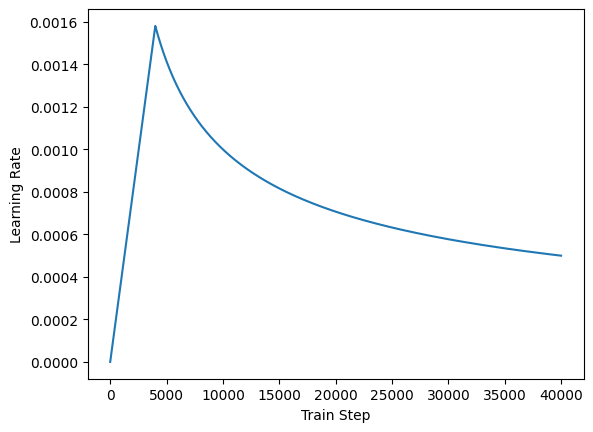

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
# calculate loss

def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype = loss.dtype)

  loss*= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask
  match = tf.cast(match, dtype = tf.float32)
  mask = tf.cast(match, dtype = tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(
    loss = masked_loss,
    optimizer = optimizer,
    metrics = [masked_accuracy]
)

In [ ]:
print("input_vocab_size =", int(tokenizers.sp.get_vocab_size().numpy()))
print("target_vocab_size =", int(tokenizers.en.get_vocab_size().numpy()))
for w in transformer.final_layer.weights:
    print(w.name, w.shape)

input_vocab_size = 1102
target_vocab_size = 939
kernel (100, 939)
bias (939,)


In [ ]:
transformer.fit(train_batches,
                epochs = 10,
                validation_data = val_batches)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - loss: 6.1824 - masked_accuracy: 1.0000 - val_loss: 4.8929 - val_masked_accuracy: 1.0000
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - loss: 4.1786 - masked_accuracy: 1.0000 - val_loss: 3.7023 - val_masked_accuracy: 1.0000
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - loss: 2.9784 - masked_accuracy: 1.0000 - val_loss: 3.0277 - val_masked_accuracy: 1.0000
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 2.3540 - masked_accuracy: 1.0000 - val_loss: 2.7046 - val_masked_accuracy: 1.0000
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - loss: 1.9061 - masked_accuracy: 1.0000 - val_loss: 2.3476 - val_masked_accuracy: 1.0000
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - loss: 1.5447 - masked_accuracy: 1.0000 - val_loss: 2.1411 - val_masked_accuracy: 1.0000
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - loss: 1.2501 - masked_accuracy: 1.0000 - val_loss: 2.1223 - val_masked_accuracy: 1.0000

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):

    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.sp.tokenize(sentence).to_tensor()

    encoder_input = sentence


    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

     predictions = predictions[:, -1:, :]

      predicted_id = tf.argmax(predictions, axis=-1)


      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
.
    text = tokenizers.en.detokenize(output)[0]

    tokens = tokenizers.en.lookup(output)[0]


    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights


In [ ]:
import tensorflow as tf
import numpy as np

def translate_all(sentences, translator, batch_size=256, max_tokens=128):

    src_tok = translator.tokenizers.sp
    tgt_tok = translator.tokenizers.en
    model   = translator.transformer


    def _warmup():
        dummy = tf.constant(["hola"])
        enc = src_tok.tokenize(dummy).to_tensor()[:, :max_tokens]
        ctx = model.encoder(enc, training=False)
        se = tgt_tok.tokenize([''])[0]
        ys = tf.fill([1, 1], tf.cast(se[0], tf.int64))
        dec = model.decoder(ys, ctx, training=False)
        _ = model.final_layer(dec)
    _warmup()

    @tf.function
    def _greedy_decode_batch(src_batch):
        enc = src_tok.tokenize(src_batch).to_tensor()[:, :max_tokens]
        context = model.encoder(enc, training=False)

        se = tgt_tok.tokenize([''])[0]
        start_id = tf.cast(se[0], tf.int64)
        end_id   = tf.cast(se[1], tf.int64)

        B  = tf.shape(enc)[0]
        ys = tf.fill([B, 1], start_id)
        finished = tf.zeros([B], dtype=tf.bool)
        t = tf.constant(0)

        def cond(t, ys, finished):
            return tf.logical_and(tf.reduce_any(~finished), t < max_tokens)

        def body(t, ys, finished):
            dec_out = model.decoder(ys, context, training=False)
            logits  = model.final_layer(dec_out)
            next_ids = tf.argmax(logits[:, -1, :], axis=-1, output_type=tf.int64)
            finished = tf.logical_or(finished, tf.equal(next_ids, end_id))
            ys = tf.concat([ys, tf.expand_dims(next_ids, 1)], axis=1)
            return t+1, ys, finished

        _, ys, _ = tf.while_loop(
            cond, body, [t, ys, finished],
            shape_invariants=[t.shape,
                              tf.TensorShape([None, None]),
                              tf.TensorShape([None])],
            parallel_iterations=1
        )
        return ys

    outputs = []
    ds = tf.data.Dataset.from_tensor_slices(tf.constant(list(sentences))).batch(batch_size)
    se_np = translator.tokenizers.en.tokenize([''])[0].numpy()
    end_id = int(se_np[1])

    for batch in ds:
        ids = _greedy_decode_batch(batch).numpy()

        trimmed = []
        for row in ids:
            row = row[1:]
            if end_id in row:
                row = row[:int(np.where(row == end_id)[0][0])]
            trimmed.append(row)

        rt = tf.ragged.constant(trimmed, dtype=tf.int64)
        texts = tgt_tok.detokenize(rt).numpy()
        outputs.extend([t.decode('utf-8') for t in texts])

    return outputs


In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
# Translate all preprocessed Spanish sentences to English
translations_en = translate_all(prc_sp_sentences, translator, batch_size=256, max_tokens=MAX_TOKENS)
print(len(translations_en), "translations")
print("Sample:", prc_sp_sentences[1], "->", translations_en[1])

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


20000 translations
Sample: vete . -> go away .


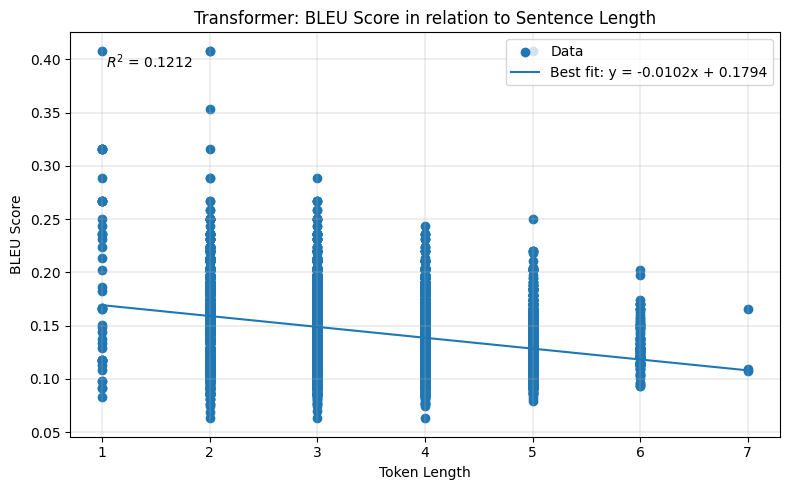

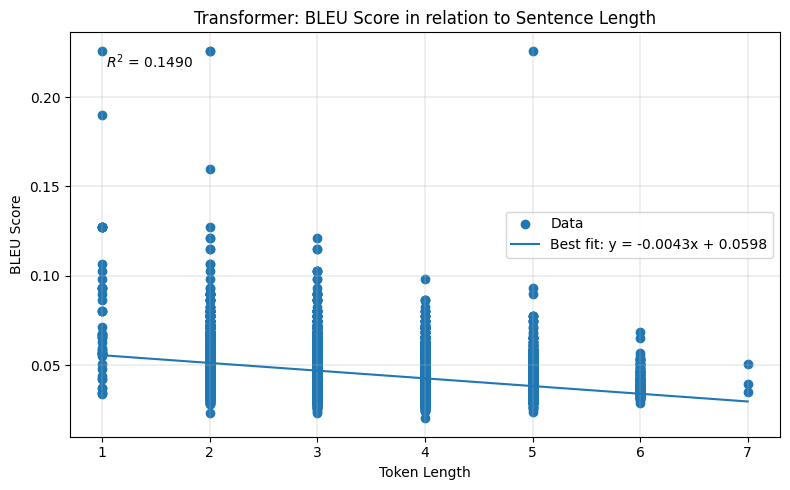

go .
go away .
go .
go away .
go .
go .
go .
go away .
hi .
he hired .
run !
there you are !
run .
i run .
who ?
who do you ?
fire !
fire !
fire !
no way !
fire !
say you .
help !
help him !
help !
help !
help !
ariving !
jump !
go away !
jump .
go away .
stop !
stop !
stop !
stop !
stop !
stop !
wait !
wait !
Avg sentence BLEU-4: 4.40
Avg sentence BLEU-2: 14.20
Avg sentence BLEU-4:  0.044039453999308684
Avg sentence BLEU-2:  0.14204799277488728

INPUT: ve .
REF: go .
HYP: go away .
Sentence BLEU-4: 6.74

INPUT: vete .
REF: go .
HYP: go away .
Sentence BLEU-4: 6.74

INPUT: vaya .
REF: go .
HYP: go .
Sentence BLEU-4: 22.59

INPUT: vayase .
REF: go .
HYP: go away .
Sentence BLEU-4: 6.74

INPUT: hola .
REF: hi .
HYP: he hired .
Sentence BLEU-4: 5.93

INPUT: corre !
REF: run !
HYP: there you are !
Sentence BLEU-4: 3.72

INPUT: corred .
REF: run .
HYP: i run .
Sentence BLEU-4: 9.82

INPUT: ¿ quien ?
REF: who ?
HYP: who do you ?
Sentence BLEU-4: 5.06

INPUT: fuego !
REF: fire !
HYP: fire !
S

In [ ]:

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


def simple_tok(s: str):

    #return s.strip().split()
    return  len(s.strip().split())


refs_tok = [r for r in prc_sp_sentences]
hyps_tok = [h for h in translations_en]
input_tok = [simple_tok(squash_space_before_punct(i)) for i in prc_en_sentences]
reference = prc_en_sentences
hypotheses = translations_en


smooth = SmoothingFunction().method3

def avg_sentence_bleu(refs_tok, hyps_tok, weights):
    scores = []

    for ref, hyp in zip(refs_tok, hyps_tok):
        if not hyp:
            scores.append(0.0)
            continue
        scores.append(sentence_bleu(ref, hyp, weights=weights, smoothing_function=smooth))

        #len.append(len(hyp))
    return sum(scores) / len(scores)

def create_plot(refs_tok, hyps_tok, weights):
    scores = []

    for ref, hyp in zip(refs_tok, hyps_tok):
        if not hyp:
            scores.append(0.0)
            continue
        scores.append(sentence_bleu(ref, hyp, weights=weights, smoothing_function=smooth))



    #xpoints = np.array(input_tok)
    #ypoints = np.array(scores)


    x = np.asarray(input_tok, dtype=float)
    y = np.asarray(scores, dtype=float)
    n = min(len(x), len(y))
    if len(x) != len(y):
        print(f"Warning: length mismatch; truncating to {n}")
        x, y = x[:n], y[:n]


    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    coef = np.polyfit(x, y, 1)           # [slope, intercept]
    poly = np.poly1d(coef)
    xs = np.linspace(x.min(), x.max(), 100)
    ys = poly(xs)

    y_hat = poly(x)
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, label="Data")
    plt.plot(xs, ys, label=f"Best fit: y = {coef[0]:.4f}x + {coef[1]:.4f}")
    plt.title("Transformer: BLEU Score in relation to Sentence Length")
    plt.xlabel("Token Length")
    plt.ylabel("BLEU Score")
    plt.legend()
    plt.grid(True, linewidth=0.3)
    plt.text(0.05, 0.95, f"$R^2$ = {r2:.4f}", transform=plt.gca().transAxes, va="top")
    plt.tight_layout()
    plt.show()

w_bleu4 = (0.25, 0.25, 0.25, 0.25)
w_bleu2 = (0.5, 0.5, 0.0, 0.0)

#avg_b4 = avg_sentence_bleu(refs_tok, hyps_tok, w_bleu4)
#avg_b2 = avg_sentence_bleu(refs_tok, hyps_tok, w_bleu2)

avg_b4 = avg_sentence_bleu(reference, hypotheses, w_bleu4)
avg_b2 = avg_sentence_bleu(reference, hypotheses, w_bleu2)

create_plot(reference, hypotheses, w_bleu2)
create_plot(reference, hypotheses, w_bleu4)

for i in range(20):
  print(reference[i])
  print(hypotheses[i])

print(f"Avg sentence BLEU-4: {100*avg_b4:.2f}")
print(f"Avg sentence BLEU-2: {100*avg_b2:.2f}")
print(f"Avg sentence BLEU-4: ", avg_b4)
print(f"Avg sentence BLEU-2: ", avg_b2)


for i in range(20):
    s = sentence_bleu(prc_en_sentences[i], translations_en[i], weights=w_bleu4, smoothing_function=smooth)
    print(f"\nINPUT: {prc_sp_sentences[i]}")
    print(f"REF: {prc_en_sentences[i]}")
    print(f"HYP: {translations_en[i]}")
    #print(f"LEN: {len[i]}")
    print(f"Sentence BLEU-4: {100*s:.2f}")

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = 'Yo lo se .'
ground_truth = 'I know it .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Yo lo se .
Prediction     : i know it .
Ground truth   : I know it .


In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([5, 6])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.sp.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.sp.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(6,), dtype=string, numpy=array([b'[START]', b'yo', b'lo', b'se', b'.', b'[END]'], dtype=object)>

In [ ]:
translated_tokens


<tf.Tensor: shape=(6,), dtype=string, numpy=array([b'[START]', b'i', b'know', b'it', b'.', b'[END]'], dtype=object)>

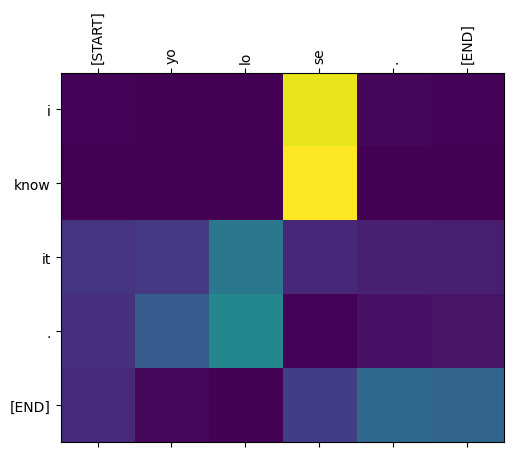

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)


In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.sp.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.sp.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

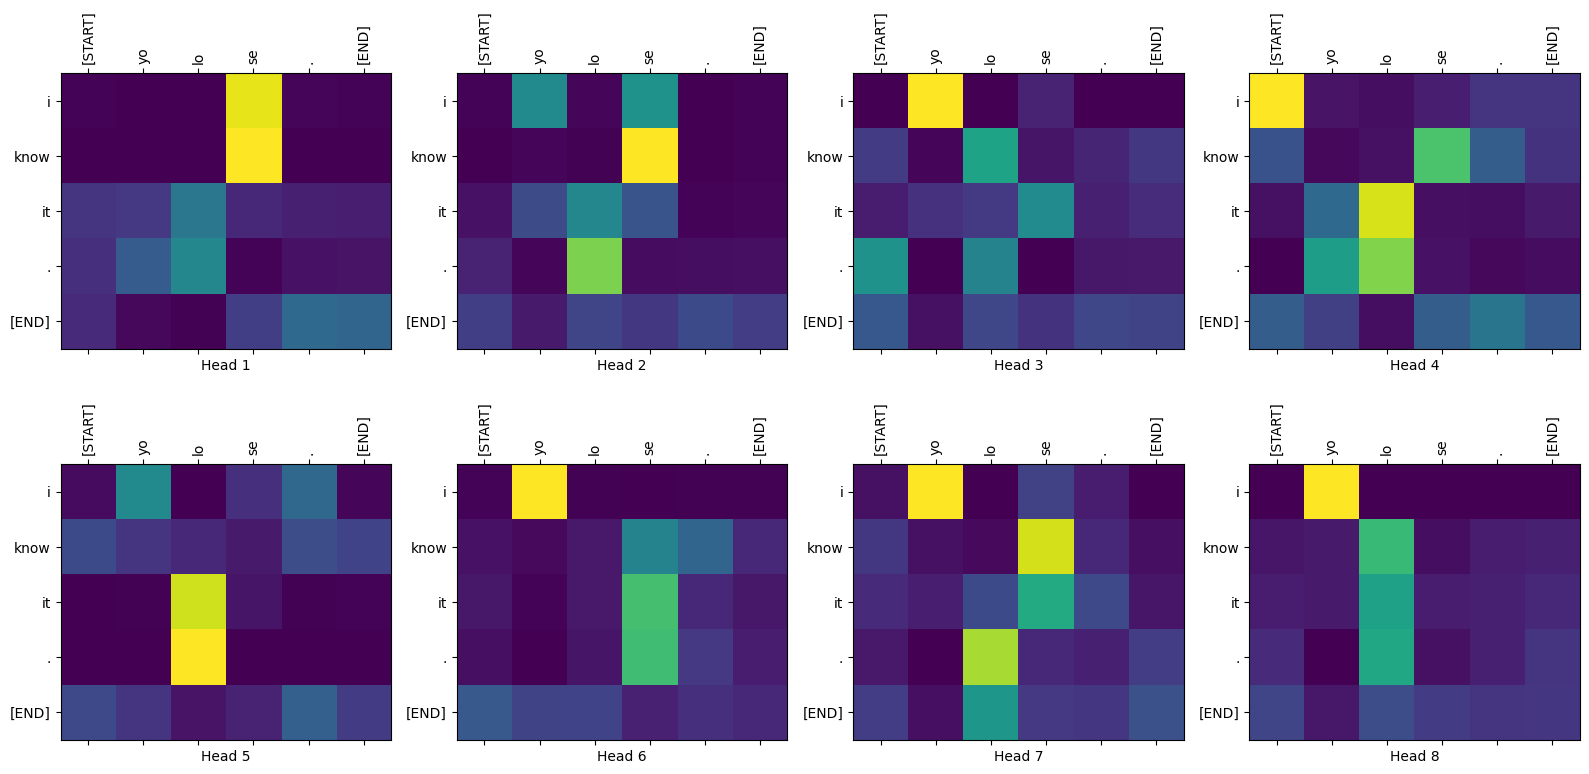

In [ ]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/us

Input:         : trata de averiguarlo.
Prediction     : try to find out .
Ground truth   : try to find out.


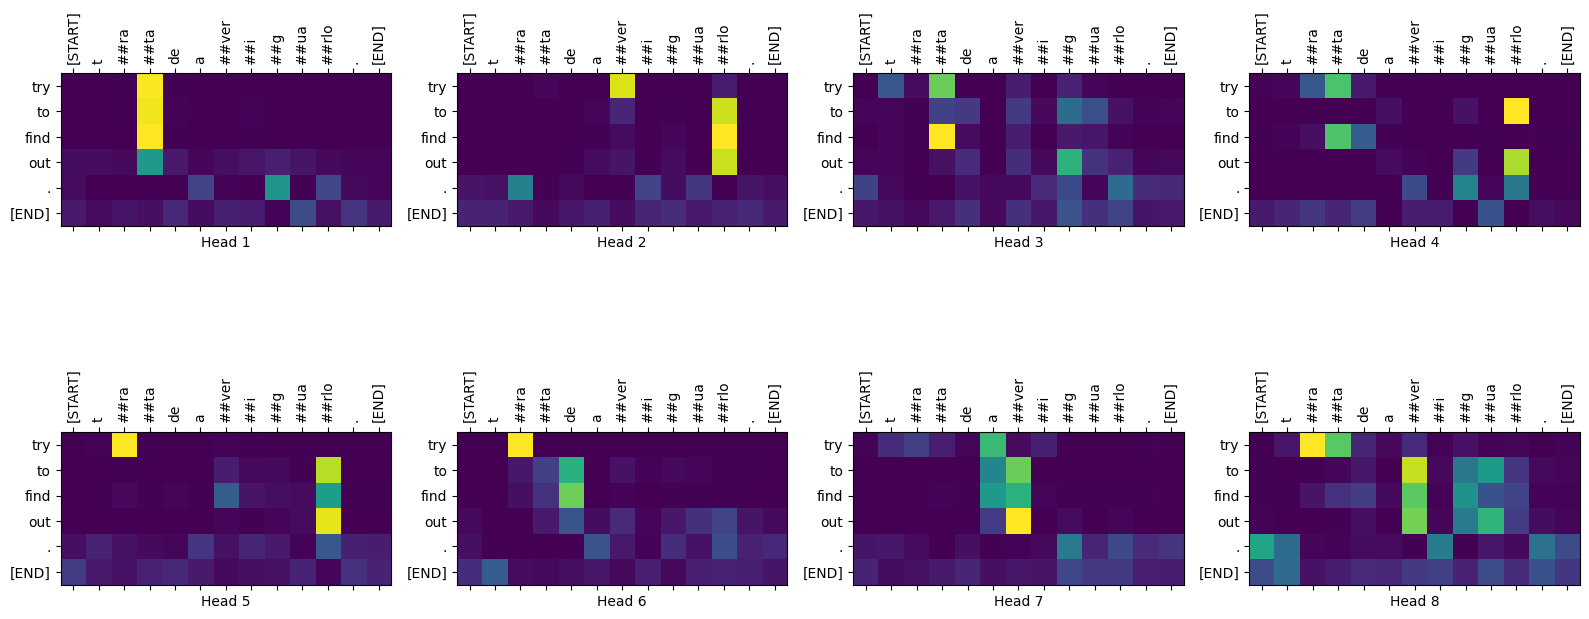

In [ ]:
sentence = 'trata de averiguarlo.'
ground_truth = 'try to find out.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'causal_self_attention_5' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - loss: 2.0622 - masked_accuracy: 0.6184 - masked_precision: 0.6181 - masked_recall: 0.6181 - masked_top_5_accuracy: 0.7819
loss: 2.0347
masked_accuracy: 0.6207
masked_precision: 0.6204
masked_recall: 0.6204
masked_top_5_accuracy: 0.7855


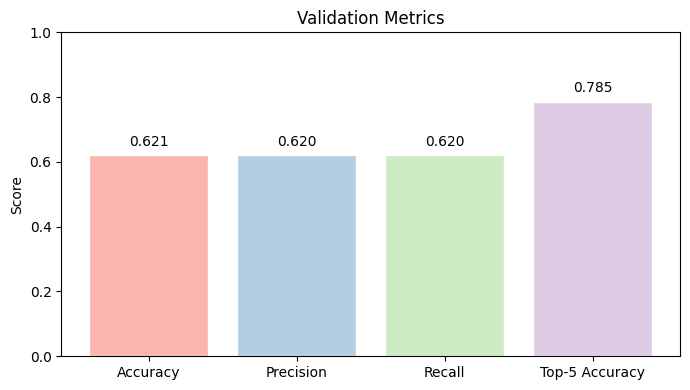

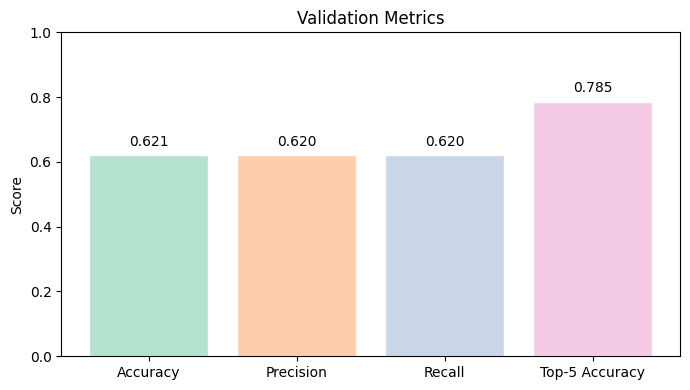

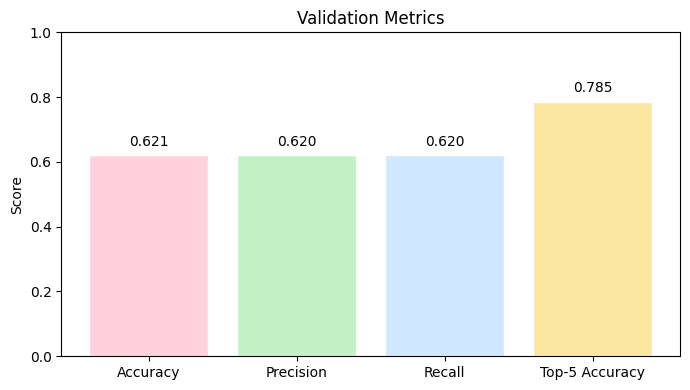

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


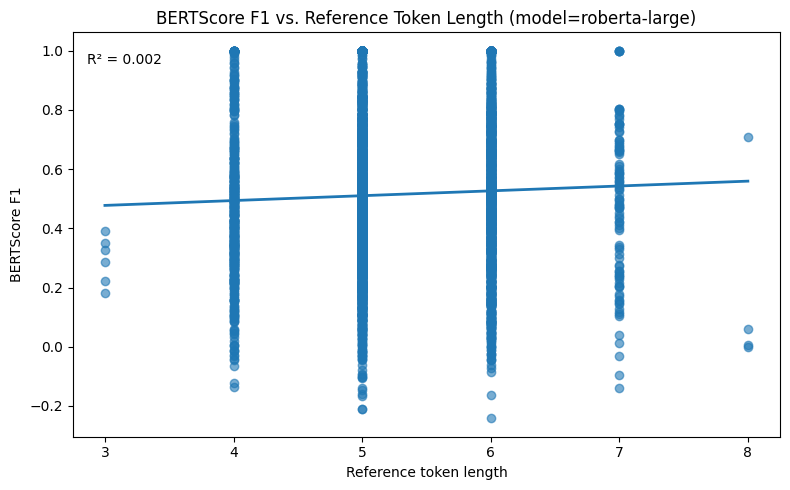

BERTScore (N=4000, model=roberta-large, rescaled):
  Precision: 0.5184
  Recall:    0.5112
  F1:        0.5148


In [ ]:

print(f"  F1:        {df_bert['F1'].mean():.4f}")